# 1.0 Buisiness Understanding
It is generally accepted that the MLB is the most stat driven of the major American sports. The sheer volume of statistics kept on each and every contest makes the sport an excellent subject for data science and machine learning experiments. 

Of this data, the records kept on each pitch thrown are among the most abundant. After all, each play begins with a pitch. Fortunately, Kaggle has just such a data set for our study. The set we have has 2.87 million samples, with 39 features, and was scraped from an MLB affiliate site. Unfortunately, not all of these features are useful to us. 

For the purposes of our study, we have 3 features we believe will be useful to a prediction task. We aim to use the break angle, break length, and the speed across the plate to predict the type of pitch that was thrown. This was done by a human arbitrar for our dataset, and a confidence interval was included in the data to denote how confident the human was in his classification of the pitch. This information is very useful in our preprocessing of the data. We don’t want to train on data that might be inaccurately classified by humans. 

In the context of a real-world application, a classification model trained with this data could be used in stat-keeping as well as enhancing the fan experience. Experts on the sport, and seasoned fans usually have a good eye for what kinds of pitches are being thrown. However, the more casual observer may not. Enter machine learning. A well-trained model would allow for real time classification, with only some simple feature extraction from broadcast images required. This information can then be displayed similarly to how radar velocity readings are displayed at the stadium and on tv, or logged in a database automatically.

The success of such a model translates into automated stat-keeping, and better fan engagement, whether you’re in the nosebleeds at your favorite stadium, or a casual observer on television.

Acceptance criteria is difficult to put a number on, because inaccuracies mean different things for different consumers of such technology. For baseball stat keepers, particularly those who work for franchises, errors could result in altering strategy from the optimal case, whereas when a fan is the consumer, the mild surprise of a strange readout would be the extent of the damage, similarly to when a radar gun obviously misreads the pitch velocity. We hope to quantify an acceptable error rate based on that which is presented us in the data we have. The confidence interval which is presented as a continuous value on a scale from 0 to 2 (even the publisher of the dataset is unsure why it ranges this way, rather than from 0 to 1) gives us an idea of how often humans misclassify pitches. By counting the number of pitches which are listed as a confidence of 0, or close to it, and representing that count as a percentage of the total data points, we can estimate how often our model would have to be correct in order to be more useful than the human stat keeper at this task.


# 1.1 Data Understanding
We are fortunate that our dataset came relatively complete. We had little missing data(based on the count of each feature). We found that only the "Code" feature had missing values. We decided not to interpolate these values, as the code is nominal data, and the result of the ensuing play after each pitch is not something we thought was wise to interpolate. We have more than enough data without these rows anyway.
    
Even with a mostly pristine dataset, we still had some housekeeping items to take care of.
    
* The first bit of data cleanup we did is to get rid of duplicate rows.<br> Even without the unique identifier, there is a sufficient number of features, many of which relate to the state of the ball game, to determine if an entry is a duplicate.<br> The probability of each and every feature being identical for 2 seperate pitches,especially considering some of the data is unrelated to the actual throw,<br> is incredibly low.
        
* The next important step we took to groom out dataset is to remove pitches where the prediction class is listed as unknown, or where it was listed as 'FA'.<br> While the data itself was in great condition as is, the overview written by the data aggregator wasn't quite as outstanding. <br>This value('FA') wasn't found in the key that was provided to translate the pitch_type codes into their real-world values, so we dropped this data.<br> Likewise, we dropped all unknown prediction classes, as it's an incorrect practice to interpolate this data.
        
       
* Next, we removed outliers in the data. It isn't always easy to differentiate true outliers from valuable data points that happen to be unusual.<br> Luckily, some of the features had very obvious outliers well over 10 times the standard deviation apart from the mean. <br> After some tweaking of the parameters,<br> we found that removing any value more than 12 standard deviations away from the mean produced acceptable numbers that make<br> sense in the context of the business case.We enlisted the advice of a subject matter expert to help us decide on what summary statistics look most realistic.
      

* Finally, we removed any data points that the classifiers were not fully confident in. <br>Fortunately, the curators of this data provided a confidence interval that we could use to remove pitches that were 'guesses' of sorts. <br>This is helpful because we can train a prediction model based only on data that is concrete.<br> We also removed any values that were missing in this step, as we have sufficient data to do so, and interpolating this data can be difficult.
    


In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../pitches.csv')

In [2]:
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']

features = ['break_angle', 'break_length', 'end_speed', 'start_speed', 'spin_rate', 'pitch_type']
#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
for feature in features:
    if feature != 'pitch_type':
        df = df[np.abs(df[feature]-df[feature].mean()) <= (12*df[feature].std())]

#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]

#Drop any data with incomplete records
df.dropna(inplace=True)

In [3]:
df.head()

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,...,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,zone
0,2.015000e+09,7.665,34.685,-11.960,0,0,-25.0,3.2,23.7,C,...,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,3.0
1,2.015000e+09,12.043,34.225,-10.085,0,0,-40.7,3.4,23.7,S,...,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,5.0
2,2.015000e+09,14.368,35.276,-11.560,0,0,-43.7,3.7,23.7,F,...,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,1.0
3,2.015000e+09,2.104,28.354,-20.540,0,0,-1.3,5.0,23.8,B,...,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,13.0
4,2.015000e+09,-10.280,21.774,-34.111,1,0,18.4,12.0,23.8,B,...,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,13.0


In [4]:
#Summary Statistics For Each Feature in the Feature Vector
desc = df[features].groupby('pitch_type').describe()
pd.options.display.max_columns = None

for feature in features:
    if feature != 'pitch_type':
        print(feature)
        display(desc[feature])

break_angle


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,177999.0,6.752947,23.580365,-68.8,-20.00,17.90,25.3,75.5
CU,142212.0,-5.089916,10.100389,-39.7,-12.30,-7.40,2.3,31.2
EP,606.0,-6.950660,6.709135,-17.9,-11.00,-9.25,-6.1,20.1
FC,90611.0,-4.102195,9.557100,-77.7,-9.70,-4.30,2.0,50.5
FF,607556.0,11.668174,26.912946,-90.0,-7.40,19.70,32.0,268.1
FO,584.0,21.860616,7.112851,-9.8,17.60,22.50,26.7,40.8
FS,26807.0,13.805428,14.960366,-50.4,9.90,17.40,23.2,60.8
FT,199366.0,17.438110,30.710764,-89.6,-14.10,31.90,38.0,267.5
KC,42339.0,-5.385994,8.310783,-32.3,-11.40,-7.00,0.7,26.5


break_length


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,177999.0,7.605248,1.328611,1.5,6.7,7.6,8.40,25.1
CU,142212.0,12.321044,1.953283,4.3,10.9,12.3,13.70,55.9
EP,606.0,16.392409,2.119038,9.1,15.4,16.6,17.70,25.6
FC,90611.0,5.822011,1.300532,0.7,5.0,5.9,6.70,12.9
FF,607556.0,3.960155,0.953348,0.1,3.3,3.9,4.50,14.8
FO,584.0,6.993151,1.265408,3.5,6.2,6.9,7.60,11.7
FS,26807.0,7.780863,1.295011,2.9,6.9,7.8,8.60,13.9
FT,199366.0,5.816509,1.000353,1.6,5.1,5.8,6.50,16.5
KC,42339.0,11.781464,1.627016,4.3,10.6,11.8,13.00,21.4


end_speed


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,177999.0,77.391643,3.260440,40.5,75.5,77.60,79.60,91.2
CU,142212.0,71.982827,3.675083,39.8,69.5,72.10,74.60,86.7
EP,606.0,62.151980,3.268667,42.8,60.9,62.55,64.10,71.3
FC,90611.0,81.773780,2.678049,59.8,80.1,81.80,83.50,92.2
FF,607556.0,85.222259,2.553622,55.9,83.6,85.30,86.90,96.5
FO,584.0,79.501541,2.160962,72.2,78.7,79.90,80.80,85.1
FS,26807.0,78.482676,2.703384,67.4,76.7,78.50,80.30,89.4
FT,199366.0,84.757576,2.474231,67.6,83.2,84.90,86.40,93.9
KC,42339.0,74.416280,3.020568,62.5,72.5,74.40,76.50,85.5


start_speed


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,177999.0,84.004879,3.471583,45.2,82.0,84.2,86.40,97.8
CU,142212.0,77.976977,3.810369,45.1,75.4,78.1,80.70,92.9
EP,606.0,67.462211,3.382225,46.7,66.3,68.0,69.30,75.7
FC,90611.0,88.488505,2.893528,65.1,86.6,88.4,90.40,99.2
FF,607556.0,93.063417,2.731367,61.0,91.3,93.1,94.90,104.5
FO,584.0,86.459760,2.308454,78.3,85.7,86.9,87.90,91.3
FS,26807.0,85.024703,2.763674,73.4,83.2,85.1,86.90,95.6
FT,199366.0,92.408473,2.648480,73.6,90.7,92.5,94.20,102.2
KC,42339.0,80.698047,3.149240,67.9,78.7,80.7,82.80,91.6


spin_rate


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,177999.0,1763.281939,429.150435,20.886,1493.18550,1782.3970,2051.78450,4745.403
CU,142212.0,1246.712218,486.952478,6.502,896.35250,1280.1665,1604.41550,6539.259
EP,606.0,1445.375018,507.600188,25.847,1202.55175,1489.5025,1784.69750,2840.261
FC,90611.0,1139.006387,495.260334,5.602,790.06150,1071.1610,1427.73500,3433.186
FF,607556.0,2190.742394,404.490005,39.943,1950.11125,2204.2895,2451.25575,6122.968
FO,584.0,1625.644817,417.392010,141.640,1374.49325,1672.5410,1902.53975,2651.096
FS,26807.0,1434.014084,502.981840,12.874,1085.02400,1441.8970,1775.47950,4009.980
FT,199366.0,2189.820537,400.024964,153.621,1952.95250,2212.0690,2446.80350,6362.899
KC,42339.0,1233.573541,474.914490,4.149,922.24100,1293.6480,1588.50850,5208.721


In [5]:
#Description of each Feature in the Feature Vector
pd.set_option('display.max_colwidth', -1)
df[features].info()
data_outline = pd.DataFrame()
data_outline['features'] = features
data_outline['description'] = ['Angle at which the pitch \'breaks\' or curves as it flies',
                              'The length that the pitch breaks while in flight',
                              'The speed of the baseball over the plate',
                              'The speed of the baseball as it leaves the hand of the pitcher',
                              'The rate at which the baseball spins, in degrees per second',
                              'The type of pitch that was thrown. This is the prediction class']
data_outline['data_type'] = ['Ordinal, Continuous'] * 5 + ['Nominal, Categorical']

data_outline

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1713868 entries, 0 to 2869369
Data columns (total 6 columns):
break_angle     float64
break_length    float64
end_speed       float64
start_speed     float64
spin_rate       float64
pitch_type      object
dtypes: float64(5), object(1)
memory usage: 91.5+ MB


,features,description,data_type
0,break_angle,Angle at which the pitch 'breaks' or curves as it flies,"Ordinal, Continuous"
1,break_length,The length that the pitch breaks while in flight,"Ordinal, Continuous"
2,end_speed,The speed of the baseball over the plate,"Ordinal, Continuous"
3,start_speed,The speed of the baseball as it leaves the hand of the pitcher,"Ordinal, Continuous"
4,spin_rate,"The rate at which the baseball spins, in degrees per second","Ordinal, Continuous"
5,pitch_type,The type of pitch that was thrown. This is the prediction class,"Nominal, Categorical"


<h1>1.2. Data Visualization</h1>

The dataset consists of 39 attributes and 15 prediction classes describing the information of the pitch thrown. Of these 39 attributes, we have chosen 5 attributes that are most likely candidates to use for the classification task. These are: <br><br>1. Break length <br>2. Break angle <br>3. Start speed <br>4. End speed and <br>5. Spin rate <br> 

We took a hierarchical approach towards the classification problem by clustering the prediction classes into three super classes, namely: <br><br>1. Fast pitches (FC – Cutter, FF – Four Seam Fastball, FS – Splitter, FT – Two Seam Fastball,SI – Sinker)
<br>2. Breaking Balls ( CU – Curveball, KC – Knuckle Curve, KN – Knuckleball, SL – Slider, SC - Screwball)
<br>3. Slow Pitches ( CH – Changeup, EP – Eephus, FO – Pitchout, PO – Pitchout, IN – Intentional Ball )




In [29]:
#separate pitches based on prediction class for visualization
# What might be a reasonable value for bounding break_length ? I picked 100.0
df = df[df.break_length <= 100.0] 
fast_pitches_super_group = df[df.pitch_type.isin(['FC','FF','FS','FT','SI'])]
fast_pitches_super_group['grouping'] = 'fast_ball'
breaking_pitches_super_group = df[df.pitch_type.isin(['CU', 'KC', 'KN', 'SL', 'SC'])]
breaking_pitches_super_group['grouping'] = 'breaking_ball'
slow_pitches_super_group = df[df.pitch_type.isin(['CH','EP','FO','PO','IN'])]
slow_pitches_super_group['grouping'] = 'slow_ball'
visualization_frames = [fast_pitches_super_group, breaking_pitches_super_group, slow_pitches_super_group]
result = pd.concat(visualization_frames)


/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [7]:
#Info about the series for each feature, to ensure all row counts match
fast_pitches_super_group[features].info()
breaking_pitches_super_group[features].info()
slow_pitches_super_group[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068310 entries, 0 to 2869369
Data columns (total 6 columns):
break_angle     1068310 non-null float64
break_length    1068310 non-null float64
end_speed       1068310 non-null float64
start_speed     1068310 non-null float64
spin_rate       1068310 non-null float64
pitch_type      1068310 non-null object
dtypes: float64(5), object(1)
memory usage: 57.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 466369 entries, 4 to 2869349
Data columns (total 6 columns):
break_angle     466369 non-null float64
break_length    466369 non-null float64
end_speed       466369 non-null float64
start_speed     466369 non-null float64
spin_rate       466369 non-null float64
pitch_type      466369 non-null object
dtypes: float64(5), object(1)
memory usage: 24.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179189 entries, 36 to 2869193
Data columns (total 6 columns):
break_angle     179189 non-null float64
break_length    179189 non-null flo

<h2>1.2.1 Histograms</h2>
In the first visualization, we looked at the relationship between the super classes as a function of one attribute at a time. This decision is in part driven by the fact that, intuitively, one would expect the distribution of fast balls' start and end speeds to fall higher than that of breaking balls, or intentionally slower pitches. So, the question we are trying to answer using this visualization is how well can we seperate the classes in this dimension?

/Users/rasimon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


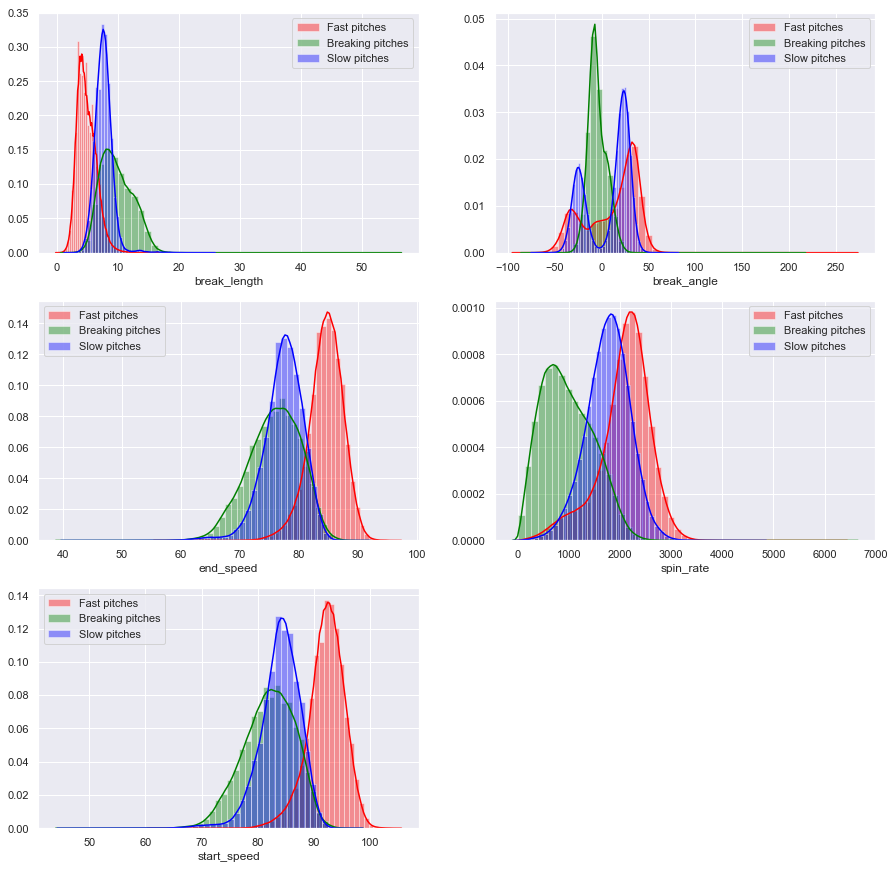

In [8]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
#plt_data = df[['break_angle', 'break_length', 'end_speed']]
#sns.violinplot(x=plt_data['break_length'])
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
sns.distplot(fast_pitches_super_group['break_length'],color='red',label="Fast pitches")
sns.distplot(breaking_pitches_super_group['break_length'],color='green', label="Breaking pitches")
sns.distplot(slow_pitches_super_group['break_length'], color='blue', label="Slow pitches")
plt.legend()

plt.subplot(3,2,2)
sns.distplot(fast_pitches_super_group['break_angle'],color='red',label="Fast pitches")
sns.distplot(breaking_pitches_super_group['break_angle'],color='green', label="Breaking pitches")
sns.distplot(slow_pitches_super_group['break_angle'], color='blue', label="Slow pitches")
plt.legend()

plt.subplot(3,2,3)
sns.distplot(fast_pitches_super_group['end_speed'],color='red',label="Fast pitches")
sns.distplot(breaking_pitches_super_group['end_speed'],color='green', label="Breaking pitches")
sns.distplot(slow_pitches_super_group['end_speed'], color='blue', label="Slow pitches")
plt.legend()

plt.subplot(3,2,4)
sns.distplot(fast_pitches_super_group['spin_rate'],color='red',label="Fast pitches")
sns.distplot(breaking_pitches_super_group['spin_rate'],color='green', label="Breaking pitches")
sns.distplot(slow_pitches_super_group['spin_rate'], color='blue', label="Slow pitches")
plt.legend()

plt.subplot(3,2,5)
sns.distplot(fast_pitches_super_group['start_speed'],color='red',label="Fast pitches")
sns.distplot(breaking_pitches_super_group['start_speed'],color='green', label="Breaking pitches")
sns.distplot(slow_pitches_super_group['start_speed'], color='blue', label="Slow pitches")
plt.legend()

The following observations can be made from the above visualizations: <br>
<br>1. It can be observed that the distribution of break_angle for breaking_balls super class is unique compared to the other two classes. It is unimodal with a mean closer to zero. Breaking pitches can be separated from the other two using the break_angle attribute. Although, it should be noted that the tails of the distributions overlap. Hence, the classification can only be done in a statistical sense with higher error bars. This makes a sort of sense in the context of the problem domain, as breaking balls typically break in one _general_ direction: down, with some variation left and right largely based on the type of breaking ball and handedness of the pitcher. Fastballs and slow pitches - fastballs in particular - might break at more extreme angles, while maintaining a small break distance, thanks to their short flight time coupled with relatively extreme spin rate(where any small deviation in spin angle will result in a change in break angle). 
<br>2. It can also be observed that using the distribution of end_speed and start_speed,  fast pitches can possibly be separated. The mean of fast_pitches is much higher than the other two distributions.
<br>3. Similarly, it can be observed that the distribution of spin rate is unique for breaking pitches. This lower mean, and wide tails may seem counter intuitive for a pitch that relies on spin to break during flight; the rate of spin has a positive correlation with the start and end speeds of the pitch, and, in spite of the name, breaking balls average the lowest velocity.<br>
<br>
Based on the histogram plots seen above, there may be a way to classify the three super classes using a combination of spin rate, start speed, end speed and break angle. The histograms also help us to decide on the type of visualization best suited for representing these distributions. With the exception of break angle, all the distributions are unimodal. So, we can use box plots to represent all the distributions and use a violin plot to represent the break angle.  

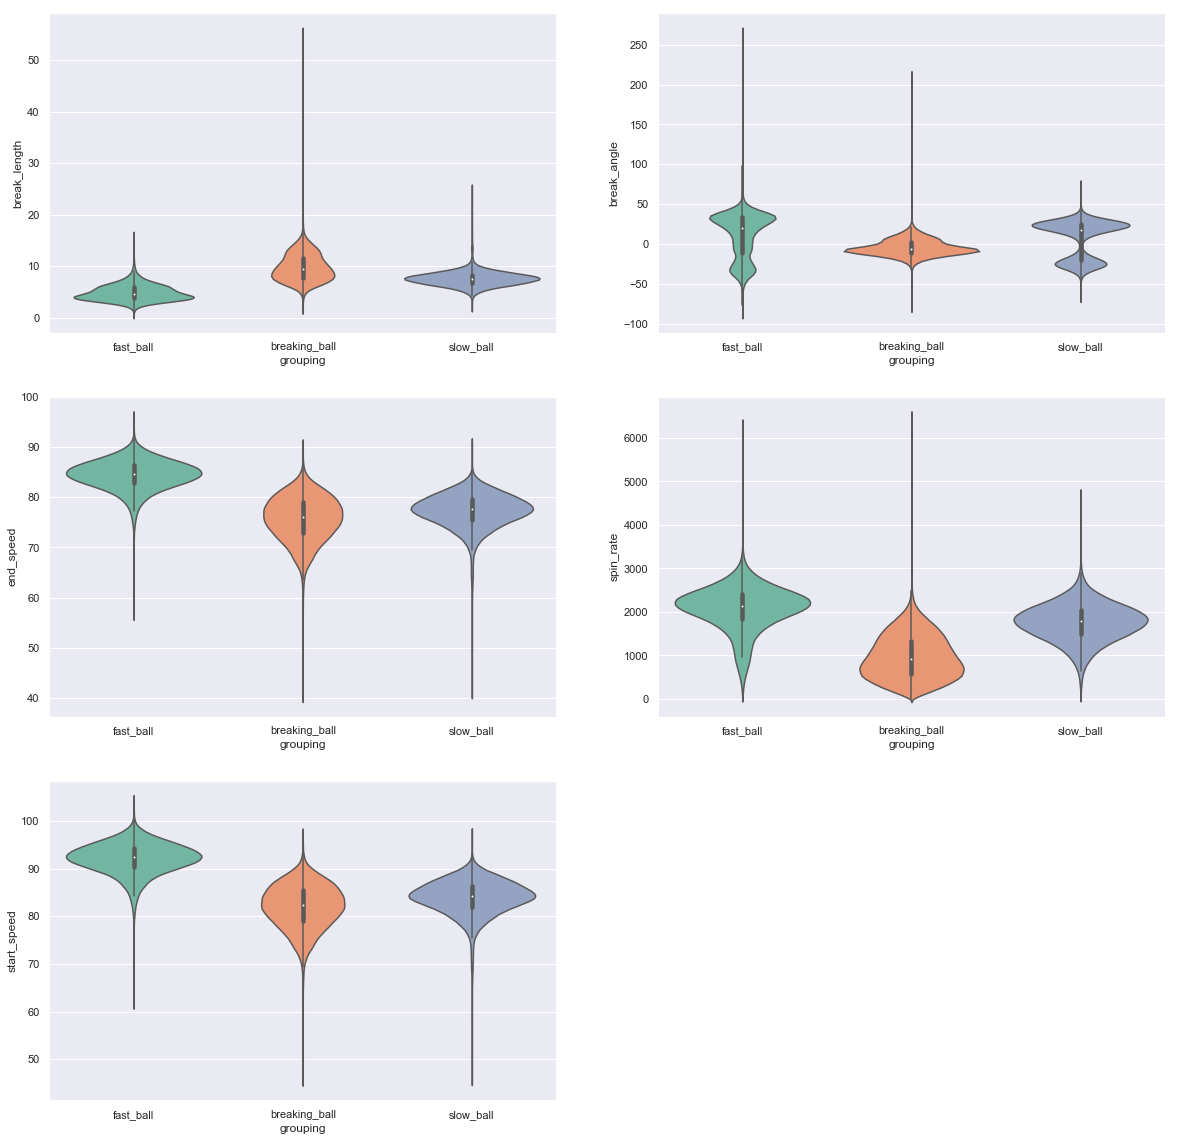

In [34]:
fig = plt.figure(figsize=(20,20))
plt.subplot(3,2,1) 
sns.violinplot(x='grouping',y="break_length", data=result, palette="Set2")

plt.subplot(3,2,2)
sns.violinplot(x='grouping', y='break_angle', data=result, palette="Set2")

plt.subplot(3,2,3)
sns.violinplot(x='grouping', y='end_speed', data=result, palette="Set2")

plt.subplot(3,2,4)
sns.violinplot(x='grouping', y='spin_rate', data=result, palette="Set2")

plt.subplot(3,2,5)
sns.violinplot(x='grouping', y='start_speed', data=result, palette="Set2")

<h2>1.2.2 Relationship plots</h2>
<br>
Since, it is not possible to uniquely classify the three classes using a single atrtibute, we decided to look at the relationship between two attributes at a time to see if the data yields for classification based on these relationships.

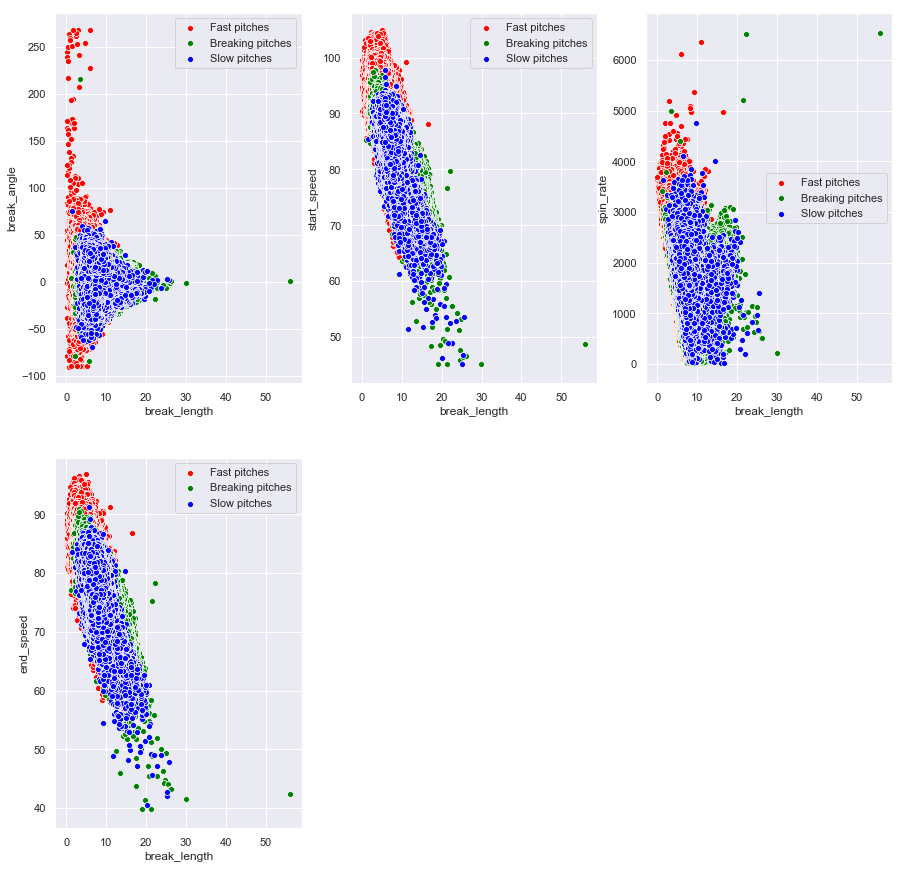

In [8]:
fig = plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
sns.scatterplot(x = fast_pitches_super_group['break_length'],y = fast_pitches_super_group['break_angle'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_length'],y = breaking_pitches_super_group['break_angle'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_length'],y = slow_pitches_super_group['break_angle'],
                color='blue',label="Slow pitches")

plt.subplot(2,3,2)
sns.scatterplot(x = fast_pitches_super_group['break_length'],y = fast_pitches_super_group['start_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_length'],y = breaking_pitches_super_group['start_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_length'],y = slow_pitches_super_group['start_speed'],
                color='blue',label="Slow pitches")

plt.subplot(2,3,3)
sns.scatterplot(x = fast_pitches_super_group['break_length'],y = fast_pitches_super_group['spin_rate'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_length'],y = breaking_pitches_super_group['spin_rate'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_length'],y = slow_pitches_super_group['spin_rate'],
                color='blue',label="Slow pitches")

plt.subplot(2,3,4)
sns.scatterplot(x = fast_pitches_super_group['break_length'],y = fast_pitches_super_group['end_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_length'],y = breaking_pitches_super_group['end_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_length'],y = slow_pitches_super_group['end_speed'],
                color='blue',label="Slow pitches")

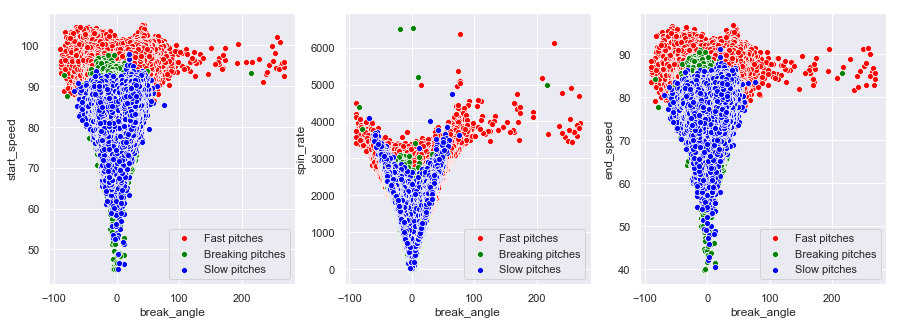

In [10]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(x = fast_pitches_super_group['break_angle'],y = fast_pitches_super_group['start_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_angle'],y = breaking_pitches_super_group['start_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_angle'],y = slow_pitches_super_group['start_speed'],
                color='blue',label="Slow pitches")

plt.subplot(1,3,2)
sns.scatterplot(x = fast_pitches_super_group['break_angle'],y = fast_pitches_super_group['spin_rate'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_angle'],y = breaking_pitches_super_group['spin_rate'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_angle'],y = slow_pitches_super_group['spin_rate'],
                color='blue',label="Slow pitches")

plt.subplot(1,3,3)
sns.scatterplot(x = fast_pitches_super_group['break_angle'],y = fast_pitches_super_group['end_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['break_angle'],y = breaking_pitches_super_group['end_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['break_angle'],y = slow_pitches_super_group['end_speed'],
                color='blue',label="Slow pitches")

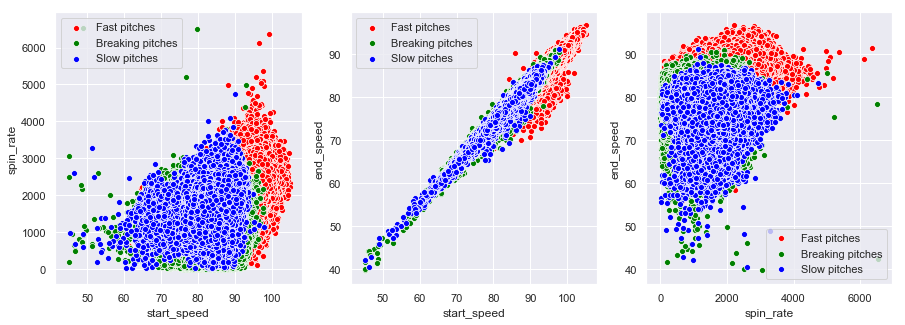

In [11]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(x = fast_pitches_super_group['start_speed'],y = fast_pitches_super_group['spin_rate'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['start_speed'],y = breaking_pitches_super_group['spin_rate'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['start_speed'],y = slow_pitches_super_group['spin_rate'],
                color='blue',label="Slow pitches")

plt.subplot(1,3,2)
sns.scatterplot(x = fast_pitches_super_group['start_speed'],y = fast_pitches_super_group['end_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['start_speed'],y = breaking_pitches_super_group['end_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['start_speed'],y = slow_pitches_super_group['end_speed'],
                color='blue',label="Slow pitches")

plt.subplot(1,3,3)
sns.scatterplot(x = fast_pitches_super_group['spin_rate'],y = fast_pitches_super_group['end_speed'],
                color='red',label="Fast pitches")
sns.scatterplot(x = breaking_pitches_super_group['spin_rate'],y = breaking_pitches_super_group['end_speed'],
                color='green',label="Breaking pitches")
sns.scatterplot(x = slow_pitches_super_group['spin_rate'],y = slow_pitches_super_group['end_speed'],
                color='blue',label="Slow pitches")

From these plots, we can see that there is no straight forward way to understand and parse the relationship between any two attributes at a time using this data. However, there exists a small cluster when break angle is plotted against start speed, end speed and spin rate.

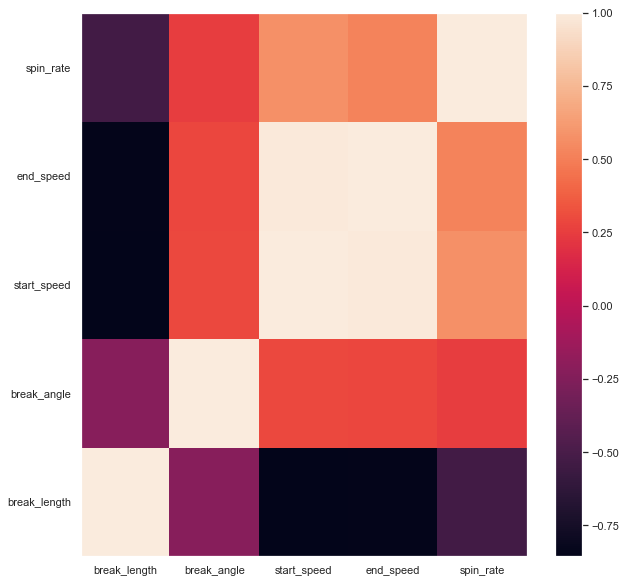

In [64]:
# plot the correlation matrix 
fig = plt.figure(figsize=(10,10))

vars_to_use = ['break_length','break_angle','start_speed', 'end_speed','spin_rate'] # pick vars
plt.pcolor(df[vars_to_use].corr()) # do the feature correlation plot

# fill in the indices
plt.yticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.xticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.colorbar()
plt.show()

Notice: Break Length and pitch velocity have a strong inverse relationship

<h1>1.3 Dimensionlity Reduction</h1>

Since it is difficult to visualize with more dimensions, we looked at reducing the dimensionality of the data to extract any relationship that can help in classifying the prediction class. We applied standard PCA on the data to reduce the 5-dimensional data to 2 -dimensions.

In [35]:
df_scaled = df[['break_length','break_angle','start_speed', 'end_speed','spin_rate']]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled) # fit data and then transform it
X_pca = pca.transform(df_scaled)

# print the components

print ('pca:', pca.components_)

pca: [[-0.00220564  0.00891132  0.00491561  0.00394462  0.999938  ]
 [-0.01224787  0.99826504  0.04210215  0.03818599 -0.00928104]]


From the PCA weights, we can see that > 99% of the variation lies in spin_rate along one axis and in break_angle along the other axis. So, we plotted the relationship between spin rate and break_angle across the original data (of all 15 prediction classes). Note that this should give similar results to the 2D relationship plot between spin_rate and break_angle seen in the earlier section. 

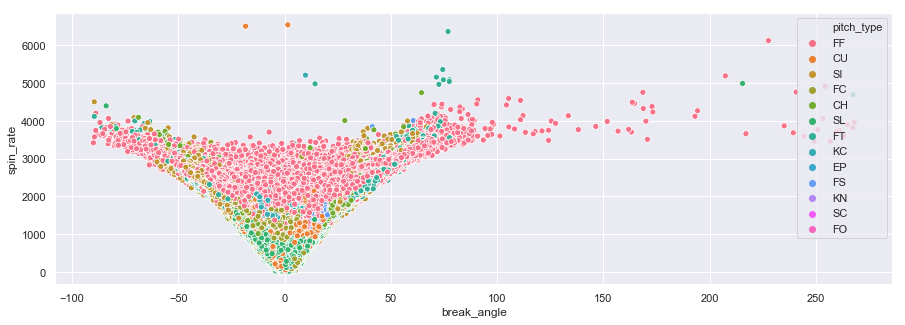

In [36]:
fig = plt.figure(figsize=(15,5))
sns.scatterplot(x = "break_angle", y = "spin_rate", hue="pitch_type", data = df)

It's difficult to visualize from the above plot on the regions that overlap. So, we took the largest clusters and independly plotted them. We can clearly see a large region of overlap between multiple clusters. 

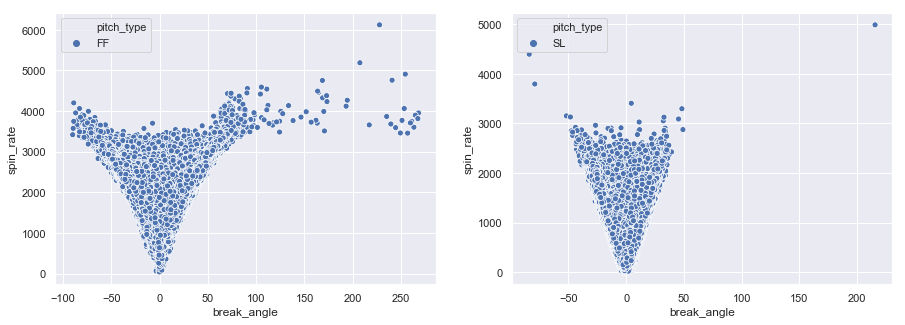

In [38]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x = "break_angle", y = "spin_rate", hue="pitch_type", data = df[df.pitch_type == 'FF'])
plt.subplot(1,2,2)
sns.scatterplot(x = "break_angle", y = "spin_rate", hue="pitch_type", data = df[df.pitch_type == 'SL'])

One thing to note from the analysis so far is that, in 2-dimensions (break_angle vs spin_rate) the data exhibits clustering albeit with a large overlap. From the 1-D visualizations, we have already observed that, the data can be easily separated using start_speed and end_speed. So, probably, the data is separable in 3-dimensions. So, the question we try to answer now is whetehr the data is separable in 3-dimensions ? So, we proceed to do PCA on the data and reduce the dimension to 3.

In [41]:
pca = PCA(n_components=3)
pca.fit(df_scaled) # fit data and then transform it
X_pca = pca.transform(df_scaled)
# print the components
print ('pca:', pca.components_)

pca: [[-0.00220564  0.00891132  0.00491561  0.00394462  0.999938  ]
 [-0.01224787  0.99826504  0.04210215  0.03818599 -0.00928104]
 [ 0.29311465  0.05798572 -0.69916054 -0.6495063   0.00612901]]


From the PCA weights, we can see that > 99% of the variation lies in spin_rate along one axis and in break_angle along the other axis. And, a large variation can be seen in start_speed and end_speed. So, we plotted the relationship between spin rate, break_angle, start_speed and end_speed across the super classes. This also corroborates the correlation plots obtained earlier in the sense that, break_length seems to not correlate with any other atttribute. (?!)

In [42]:
df_fast_0 = fast_pitches_super_group['spin_rate'].apply(lambda x: x*0.99994045)
df_fast_1 = fast_pitches_super_group['break_angle'].apply(lambda x: x*0.99835162)
df_fast_2_0 = fast_pitches_super_group['start_speed'].apply(lambda x: x*-0.73109002) 
df_fast_2_1 = fast_pitches_super_group['end_speed'].apply(lambda x: x*-0.67989697)
df_fast_2 = df_fast_2_0.add(df_fast_2_1)

df_breaking_0 = breaking_pitches_super_group['spin_rate'].apply(lambda x: x*0.99994045)
df_breaking_1 = breaking_pitches_super_group['break_angle'].apply(lambda x: x*0.99835162)
df_breaking_2_0 = breaking_pitches_super_group['start_speed'].apply(lambda x: x*-0.73109002) 
df_breaking_2_1 = breaking_pitches_super_group['end_speed'].apply(lambda x: x*-0.67989697)
df_breaking_2 = df_breaking_2_0.add(df_breaking_2_1)

df_slow_0 = slow_pitches_super_group['spin_rate'].apply(lambda x: x*0.99994045)
df_slow_1 = slow_pitches_super_group['break_angle'].apply(lambda x: x*0.99835162)
df_slow_2_0 = slow_pitches_super_group['start_speed'].apply(lambda x: x*-0.73109002) 
df_slow_2_1 = slow_pitches_super_group['end_speed'].apply(lambda x: x*-0.67989697)
df_slow_2 = df_slow_2_0.add(df_slow_2_1)



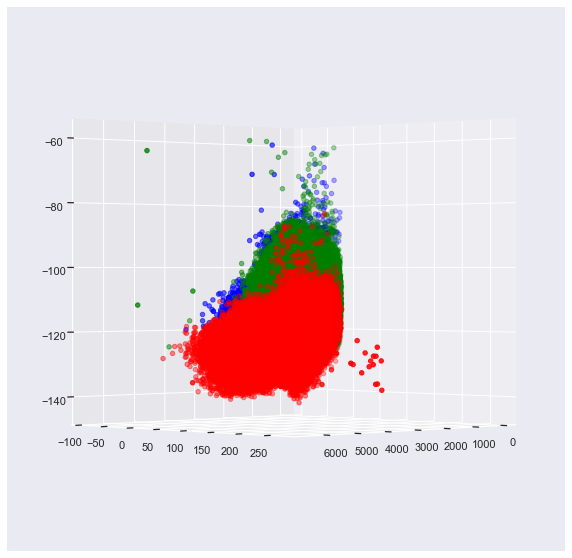

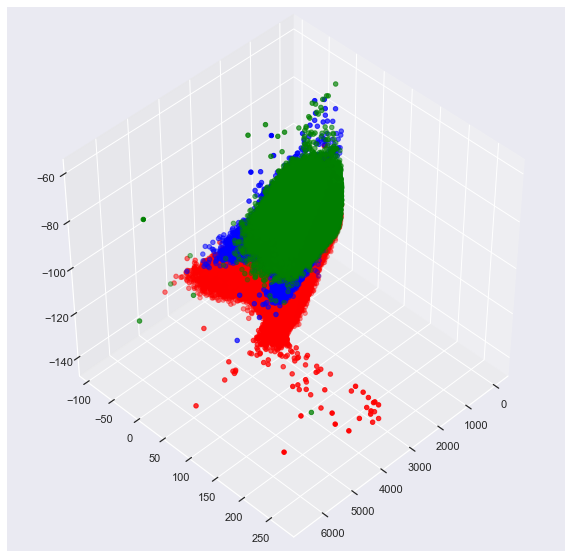

In [43]:
#Source: https://python-graph-gallery.com/370-3d-scatterplot/
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure(figsize=(10,10))

ax = fig1.add_subplot(111, projection='3d')
ax.scatter(df_fast_0, df_fast_1,df_fast_2,color='red')
ax.scatter(df_breaking_0, df_breaking_1,df_breaking_2,color='green')
ax.scatter(df_slow_0, df_slow_1,df_slow_2,color='blue')
ax.view_init(0, 45)
plt.show()

fig2 = plt.figure(figsize=(10,10))

ax = fig2.add_subplot(111, projection='3d')
ax.scatter(df_fast_0, df_fast_1,df_fast_2,color='red')
ax.scatter(df_breaking_0, df_breaking_1,df_breaking_2,color='green')
ax.scatter(df_slow_0, df_slow_1,df_slow_2,color='blue')
ax.view_init(45, 45)
plt.show()

From these plots, it appears that the data is separable on a 3-dimensional surface. Probably would require a non-linear PCA  algorithm to easily classify the data.

<h1>1.4 t-SNE <h1>

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_scaled)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1713868 samples in 20.338s...
[t-SNE] Computed neighbors for 1713868 samples in 173.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1713868
[t-SNE] Computed conditional probabilities for sample 2000 / 1713868
[t-SNE] Computed conditional probabilities for sample 3000 / 1713868
[t-SNE] Computed conditional probabilities for sample 4000 / 1713868
[t-SNE] Computed conditional probabilities for sample 5000 / 1713868
[t-SNE] Computed conditional probabilities for sample 6000 / 1713868
[t-SNE] Computed conditional probabilities for sample 7000 / 1713868
[t-SNE] Computed conditional probabilities for sample 8000 / 1713868
[t-SNE] Computed conditional probabilities for sample 9000 / 1713868
[t-SNE] Computed conditional probabilities for sample 10000 / 1713868
[t-SNE] Computed conditional probabilities for sample 11000 / 1713868
[t-SNE] Computed conditional probabilities for sample 12000 / 1713868
[t-SNE] Computed c

In [ ]:
References:
https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
Visualizing Data Using t-SNE:https://www.youtube.com/watch?v=RJVL80Gg3lA
Image attachments sourced from:https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
In the first step, t-SNE computes the similarities between points in a higher dimensional space. It measures similarities to nearby points by measuring the normalized probability densities pij, of points xj in a gaussian region surrounding the point of interest xi. image.png, and
image.png
pij gives a measure of similarity between points xi and xj.If two points are closer in a higher dimensional space, pij is large, as can be evidenced from the above equation, where, when the distance between xi and xj tends to zero, the gaussian attains its maximum. And, if the points are far apart, pij is small.
In the next step, t-SNE learns a lower dimensional map of y1, y2,...yn such that the similarities between any points yi and yj closely resembles pij. The similarities in the lower dimensional map are measured using a student t-distribution (and hence the name t-SNE): image.png
As the higher dimension data is collapsed to lower dimension data, the dissimilar points in the higher dimension needs to be spread out even more in the lower dimension to get the same similarity value. Heavy tailed student t-distribution helps in distributing dissimilar points in a gaussian distributed region in a higher dimension far apart in lower dimension.
t- SNE algorithm learns the lower dimensional map by performing Gradient-descent on the lower dimensional data with a cost function defined by the Kullback–Leibler divergence: image.png
It can be seen that when pij is large, the cost function is large resulting in a large penalty on qij driving it towards the optimum value. Thus, it works best for points with high similarity.